## Scaling estimates figure

In [13]:
#import gsw as sw # Gibbs seawater package

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline

from matplotlib.ticker import FormatStrFormatter
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import scipy.stats
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [14]:
sns.set_context('paper')
sns.set_style('white')

In [15]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
time = CanyonStateOut.variables['T']

In [16]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 147.5 # Shelf break depth
s = 0.005 # shelf slope 
W = 8300 # mid-length width
Hh=97.5 # head depth
Hr = 132.0 # rim depth at DnS
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return((f*L)/(N))
    
def Ro(U=0.37,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the ability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Bu(N=5.5E-3,f=9.66E-5,W=8300,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*W))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)



In [17]:
import canyon_records 
import nocanyon_records

records = canyon_records.main()
recordsNoC = nocanyon_records.main()

In [18]:
# records2 has all the runs without the ones where K_bg changes. I don't want to use this ones for fitting the data
ind = [0,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19,20,21]
       
records2 = []
for ii in ind:
    records2.append(records[ii])


In [19]:
# records3 has all the runs without the ones where K_bg changes and run with low U high N.
ind = [0,3,4,5,6,7,8,9,12,13,14,15,16,17,18,19,21]
records3 = []
for ii in ind:
    records3.append(records[ii])


In [20]:
select_rec = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]

for ind in select_rec:
    file = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(records[ind].exp_code,
                                                                                records[ind].exp_code,
                                                                                records[ind].run_num))
    fileNoC = ('/ocean/kramosmu/MITgcm/TracerExperiments/%s/HCW_TrMass_%s%s.csv' %(recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].exp_code,
                                                                                   recordsNoC[ind].run_num))
    
    
    #file = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(records[ind].exp_code,records[ind].run_num))
    #         +'advTracer_CS_transports.nc')
    #fileNoC = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(recordsNoC[ind].exp_code,recordsNoC[ind].run_num))
    #            +'advTracer_CS_transports.nc')
    #filedif = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(records[ind].exp_code,records[ind].run_num))
    #         +'difTracer_CS_transports.nc')
    #fileNoCdif = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(recordsNoC[ind].exp_code,recordsNoC[ind].run_num))
    #            +'difTracer_CS_transports.nc')
    
    #file2 = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(records[ind].exp_code,records[ind].run_num))
    #         +'water_CS_transports.nc')
    #fileNoC2 = (('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s' %(recordsNoC[ind].exp_code,recordsNoC[ind].run_num))
    #            +'water_CS_transports.nc')
    
    
    
    print(file)
    dfcan = pd.read_csv(file)
    dfnoc = pd.read_csv(fileNoC)
   
    #dfcan = xr.open_dataset(file)
    #dfnoc = xr.open_dataset(fileNoC)
    #dfcandif = xr.open_dataset(filedif)
    #dfnocdif = xr.open_dataset(fileNoCdif)
   
   
    #dfcan2 = xr.open_dataset(file2)
    #dfnoc2 = xr.open_dataset(fileNoC2)
   
    records[ind].HCW = dfcan['HCW']
    recordsNoC[ind].HCW = dfnoc['HCW']
    
    records[ind].HCWTr1 = dfcan['HCWTr1']
    recordsNoC[ind].HCWTr1 = dfnoc['HCWTr1']
    
    #records[ind].HCW = dfcan2.Vert_water_trans_sb
    #recordsNoC[ind].HCW = dfnoc2.Vert_water_trans_sb
    
    records[ind].TrMass = dfcan['TrMassHCW']
    recordsNoC[ind].TrMass = dfnoc['TrMassHCW']
    records[ind].TrMassTr1 = dfcan['TrMassHCWTr1']
    recordsNoC[ind].TrMassTr1 = dfnoc['TrMassHCWTr1']
    records[ind].TrMassTr2 = dfcan['TrMassHCWTr2']
    recordsNoC[ind].TrMassTr2 = dfnoc['TrMassHCWTr2']

    records[ind].TrMassTot = dfcan['TotTrMass']
    recordsNoC[ind].TrMassTot = dfnoc['TotTrMass']
    records[ind].TrMassTotTr2 = dfcan['TotTrMassTr2']
    recordsNoC[ind].TrMassTotTr2 = dfnoc['TotTrMassTr2']
    records[ind].TrMassTotTr1 = dfcan['TotTrMassTr1']
    recordsNoC[ind].TrMassTotTr1 = dfnoc['TotTrMassTr1']

    #records[ind].TrMass = dfcan.Vert_adv_trans_sb + dfcandif.Vert_dif_trans_sb
    #recordsNoC[ind].TrMass = dfnoc.Vert_adv_trans_sb + dfnocdif.Vert_dif_trans_sb


/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun38.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun37.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun36.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun45.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun73.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun75.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun67.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun51.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun69.csv
/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/HCW_TrMass_CNTDIFFrun71.csv
/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/HCW_TrMass_3DVISCrun01.csv
/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/HCW_TrMass_3DVISCrun02.csv
/ocean/kramosmu/MITgcm/TracerExperiments/3DVISC/HCW_TrMass_3DVISCrun03.csv
/ocea

In [21]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['N2_tt08','N2_tt10','N2_tt12','N2_tt14','N2_tt16',]
key0 = 'N2_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/N2_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
    
    maxd3 = max(df_anom[keys[0]][26:])   # 22:26 for other scaling
    maxd4 = max(df_anom[keys[1]][26:])   
    maxd5 = max(df_anom[keys[2]][26:])   
    maxd6 = max(df_anom[keys[3]][26:])   
    maxd7 = max(df_anom[keys[4]][26:])   
    
    record.maxN = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.stdN = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
  
    maxd3a = max(df_anom[keys[0]][22:26])   # 22:26 for other scaling
    maxd4a = max(df_anom[keys[1]][22:26])   
    maxd5a = max(df_anom[keys[2]][22:26])   
    maxd6a = max(df_anom[keys[3]][22:26])   
    maxd7a = max(df_anom[keys[4]][22:26])   
    
    record.maxNabove = np.mean(np.array([maxd3a,maxd4a,maxd5a,maxd6a,maxd7a]))
    record.stdNabove = np.std(np.array([maxd3a,maxd4a,maxd5a,maxd6a,maxd7a]))
  

In [22]:
# Save mean maximum N of days 3-6 and std for each run.

keys = ['dTrdz_tt08','dTrdz_tt10','dTrdz_tt12','dTrdz_tt14','dTrdz_tt16']
key0 = 'dTrdz_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/dTr1dz_%s_%s.csv' %
                 (record.name,stname))
    df = pd.read_csv(filename1)
    
    df_anom=(df.sub(df[key0].squeeze(),axis=0)).add(df[key0][0])
        
    maxd3 = min(df_anom[keys[0]][22:26])   
    maxd4 = min(df_anom[keys[1]][22:26])   
    maxd5 = min(df_anom[keys[2]][22:26])   
    maxd6 = min(df_anom[keys[3]][22:26])   
    maxd7 = min(df_anom[keys[4]][22:26])   
    
 
    record.maxdTrdz = np.mean(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.stddTrdz = np.std(np.array([maxd3,maxd4,maxd5,maxd6,maxd7]))
    record.inidTrdz = df[key0][30]
print('The initial tracer gradient is %f ' %(-1*record.inidTrdz))

The initial tracer gradient is 0.035983 


In [23]:
keys = ['Tr_profile_tt08','Tr_profile_tt10','Tr_profile_tt12','Tr_profile_tt14','Tr_profile_tt16']
key0 = 'Tr_profile_tt00'
stname = 'DnC' # Station at downstream side of canyon

for record in records:
    
    filename1 = ('/ocean/kramosmu/OutputAnalysis/outputanalysisnotebooks/results/metricsDataFrames/Tr1_profile_%s_%s.csv' % (record.name,stname))
    df = pd.read_csv(filename1)
    df_anom=(df.sub(df[key0].squeeze(),axis=0))
    maxd4 = np.mean(df[keys[0]][25:32])   
    maxd5 = np.mean(df[keys[1]][25:32])   
    maxd6 = np.mean(df[keys[2]][25:32]) 
    maxd7 = np.mean(df[keys[3]][25:32])  
    maxd8 = np.mean(df[keys[4]][25:32])  
    
     
    maxd0 = df[key0][29]
    
    
    record.maxTr = np.mean(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    record.stdTr = np.std(np.array([maxd4,maxd5,maxd6,maxd7,maxd8]))
    
    
    record.TrSB = maxd0
Ctop = df[key0][0]

The rms error for N/No above is 0.055551
The rms error for N/N0 below is 0.128879
The rms error for dTr/dz above is 0.066565
The rms error for C/Co is 0.001105
The rms error for Phi is 0.149721
The rms error for PhiTr/1E5 above is 0.072764
-0.0359832763672


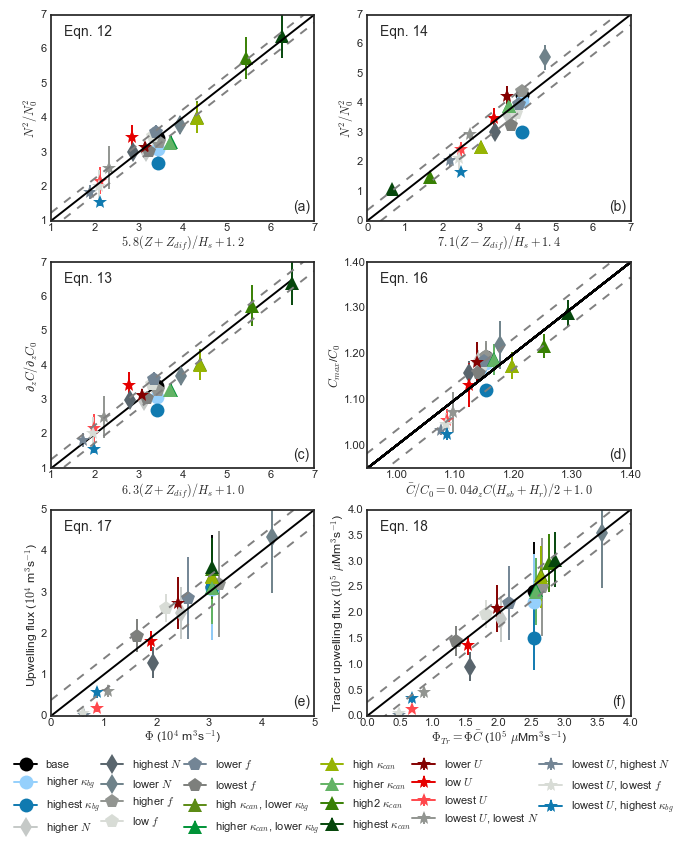

In [24]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.48,9.05)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

t=6 # days

# Tr
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg)) 
    
    
    plt1 = ax0.errorbar((5.76*((Z+Zdif)/Hs))+1.20,rec.maxNabove/(rec.N**2),
                        yerr = rec.stdNabove/(rec.N**2), # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    
    rec.Z = Z
    rec.Zdif = Zdif
    
    ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
    ax0.set_xlabel(r'$5.8(Z+Z_{dif})/H_s+1.2$',labelpad=0.5)

maxN_array_Kv = np.array([rec.maxNabove/(rec.N**2) for rec in records2])
tilt_array_Kv = np.array([(rec.Z+rec.Zdif)/Hs for rec in records2])
x_fit = np.linspace(1.0, 7, 50)

mean_sq_err = np.mean(((maxN_array_Kv)-(5.76*tilt_array_Kv+1.20))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for N/No above is %f' %mean_sq_err)

ax0.plot(np.linspace(1.0, 7, 50),np.linspace(1.0, 7, 50),'k-')

ax0.set_ylim(1,7)
ax0.set_xlim(1,7)

ax0.text(0.92,0.05,'(a)',transform=ax0.transAxes,fontsize=10)
ax0.text(0.05,0.9,'Eqn. 12',transform=ax0.transAxes,fontsize=10)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg)) 
    
    
    plt1 = ax1.errorbar((7.07*((Z-Zdif)/Hs))+1.35,rec.maxN/(rec.N**2),
                        yerr = rec.stdN/(rec.N**2), # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    
    rec.Z = Z
     
    ax1.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
    ax1.set_xlabel(r'$7.1(Z-Z_{dif})/H_s+1.4$',labelpad=0.5)

maxN_array = np.array([rec.maxN/(rec.N**2) for rec in records2])
tilt_array = np.array([((rec.Z-rec.Zdif)/Hs) for rec in records2])
x_fit = np.linspace(0, 7, 50)

mean_sq_err = np.mean((maxN_array-(7.07*tilt_array+1.35))**2)

upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for N/N0 below is %f' %mean_sq_err)

ax1.plot(np.linspace(0, 7, 50),np.linspace(0, 7, 50),'k-')
ax1.set_ylim(0,7)
ax1.set_xlim(0,7)
ax1.text(0.92,0.05,'(b)',transform=ax1.transAxes,fontsize=10)
ax1.text(0.05,0.9,'Eqn. 14',transform=ax1.transAxes,fontsize=10)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
ax2.plot(np.linspace(1,6.5, 50),np.linspace(1,6.5, 50),'k-')

for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    plt1 = ax2.errorbar(6.27*((Z+Zdif)/Hs)+0.98,rec.maxdTrdz/rec.inidTrdz,
                        yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
   
    rec.Z = Z
    rec.Zdif = Zdif
    ax2.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
    ax2.set_xlabel(r'$6.3(Z+Z_{dif})/H_s+1.0$',labelpad=0.5)

maxN_array = np.array([rec.maxdTrdz/rec.inidTrdz for rec in records2])
tilt_array = np.array([(rec.Z+rec.Zdif)/Hs for rec in records2])
x_fit = np.linspace(1,7, 50)

mean_sq_err = np.mean(((maxN_array)-(6.27*tilt_array+0.98))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for dTr/dz above is %f' %mean_sq_err)
ax2.set_ylim(1,7)
ax2.set_xlim(1,7)
ax2.text(0.92,0.05,'(c)',transform=ax2.transAxes,fontsize=10)
ax2.text(0.05,0.9,'Eqn. 13',transform=ax2.transAxes,fontsize=10)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer Conc %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    ax3.plot(np.linspace(0,1.4,50),np.linspace(0,1.4,50),'k-')
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    dTrdz = -rec.inidTrdz*(6.27*(((Z+Zdif)/Hs))+0.98)
    plt1 = ax3.errorbar((0.08*(dTrdz*(Hh+132.0)/2.0))/rec.TrSB + 7.19/rec.TrSB,rec.maxTr/rec.TrSB,
                        yerr = rec.stdTr/rec.TrSB,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    rec.Z = Z
    rec.Zdif = Zdif
    rec.dTr = dTrdz
    ax3.set_xlim(0.95,1.4)
    ax3.set_ylim(0.95,1.4)
    #ax3.set_title('Max tracer concetration between head nad sh, Dn')
    ax3.set_ylabel('$C_{max}$/$C_{0}$',labelpad=0.5)
    ax3.set_xlabel(r'$\bar{C}/C_{0}=%1.2f\partial_zC(H_{sb}+H_r)/2+%1.1f$' %((0.08/2),(7.19/rec.TrSB)),labelpad=0.5)

fmt = FormatStrFormatter('%1.2f')
ax3.xaxis.set_major_formatter(fmt)
ax3.yaxis.set_major_formatter(fmt)

ax3.tick_params(axis='x', pad=1)
ax3.tick_params(axis='y', pad=1)

maxN_array = np.array([rec.maxTr/rec.TrSB for rec in records2])
tilt_array = np.array([(0.08*(rec.dTr*(Hh+132.0)/2.0))/rec.TrSB+7.19/rec.TrSB for rec in records2])
x_fit = np.linspace(0,1.4, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for C/Co is %f' %mean_sq_err)

ax3.text(0.92,0.05,'(d)',transform=ax3.transAxes,fontsize=10)
ax3.text(0.05,0.9,'Eqn. 16',transform=ax3.transAxes,fontsize=10)

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t=4
for rec,recNoC in zip(records,recordsNoC):
    

    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    
    HA2013=((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    #Phi = np.mean(np.array([(can_eff[ii]) for ii in range (8,14)]))
      
    plt1 = ax4.errorbar(HA2013*(rec.u*W*Dh(rec.f,L,rec.N))/1E4,Phi/1E4,
                        yerr=Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    rec.Phi = Phi/1E4
    rec.HA2013 = HA2013*(rec.u*W*Dh(rec.f,L,rec.N))/1E4

#ax4.set_title('Upwelling flux scaled as HA2013 using Napprox')
ax4.set_ylabel(r'Upwelling flux ($10^4$ m$^3$s$^{-1}$)  ',labelpad=0.5)
ax4.set_xlabel(r'$\Phi$ ($10^4$ m$^3$s$^{-1}$)',labelpad=0.5)
    
maxN_array = np.array([rec.Phi for rec in records3])
tilt_array = np.array([rec.HA2013 for rec in records3])
x_fit = np.linspace(0,5, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax4.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax4.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for Phi is %f' %mean_sq_err)

ax4.plot(np.linspace(0,5, 50),np.linspace(0,5, 50),'k-')
ax4.set_ylim(0,5.0)
ax4.text(0.92,0.05,'(e)',transform=ax4.transAxes,fontsize=10)
ax4.text(0.05,0.9,'Eqn. 17',transform=ax4.transAxes,fontsize=10)
    
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
for rec,recNoC in zip(records,recordsNoC):    
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    
    Capprox=(0.08*(rec.dTr*(Hh+132.0)/2.0))+7.19
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,rec.N))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    mass_can_eff = rec.TrMass
    can_eff = rec.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    phiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    plt1 = ax5.errorbar(HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                        (phiTr)/1E5,
                        yerr = phiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    rec.PhiTr = (phiTr)/1E5
    rec.PhiTrScale = HA2013*(Capprox)/1E5
     
ax5.set_xlabel(r'$\Phi_{Tr}=\Phi \bar{C}$ ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)
ax5.set_ylabel(r'Tracer upwelling flux ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)

maxN_array = np.array([rec.PhiTr for rec in records3])
tilt_array = np.array([rec.PhiTrScale for rec in records3])
x_fit = np.linspace(0,4, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax5.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax5.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for PhiTr/1E5 above is %f' %mean_sq_err)

ax5.set_ylim(0,4)
ax5.plot(np.linspace(0,4, 50),np.linspace(0,4, 50),'k-')
ax5.text(0.93,0.05,'(f)',transform=ax5.transAxes,fontsize=10)
ax5.text(0.05,0.9,'Eqn. 18',transform=ax5.transAxes,fontsize=10)

    
ax5.legend(bbox_to_anchor=(1.2,-0.15),ncol=6, columnspacing=0.1)
    
ax0.tick_params(axis='x', pad=1)
ax1.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax4.tick_params(axis='x', pad=1)
ax5.tick_params(axis='x', pad=1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)
ax5.tick_params(axis='y', pad=3)

plt.savefig('figure9.eps',format='eps',bbox_inches='tight')

print(rec.inidTrdz)

In [28]:
print ("\t".join(['Exp name&','Phi 1E4&','PhiTr 1E5&', 'Total HCW $10^{10}$ m$^3$&', 
                  'CanyonHCW (%)&',  'TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMassHCW (%)&',
                  'TotalTrMass $10^{11}$ $\mu$Mm$^3$&', 'CanyonTrMass (%) ' ]))

    
for rec,recNoC in zip(records,recordsNoC):
    
    can_eff = rec.HCW #-recNoC.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    mass_can_eff = rec.TrMass #-recNoC.TrMass
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    phiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
                   
    print ("\t".join(['%s\t%0.2f$\pm$%0.2f\t&%0.2f$\pm$ %0.2f\t&%.2f\t&%.2f\t\t&%.2f\t\t&%.2f\t&%.2f\t\t&%.2f\t ' 
                      % (rec.name,
                         Phi/1E4,Phi_std/1E4,
                         phiTr/1E5, phiTr_std/1E5,
                         (rec.HCW[18]-rec.HCW[8])/1E10,
                         ((rec.HCW[18]-rec.HCW[8]-(recNoC.HCW[18]-recNoC.HCW[8]))/(rec.HCW[18]-rec.HCW[8]))*100,
                         (rec.TrMass[18]-rec.TrMass[8])/1E11,
                         (((rec.TrMass[18]-rec.TrMass[8])-
                           (recNoC.TrMass[18]-recNoC.TrMass[8]))/(rec.TrMass[18]-rec.TrMass[8]))*100,
                         (rec.TrMassTot[18]-rec.TrMassTot[8])/1E11,
                         (((rec.TrMassTot[18]-rec.TrMassTot[8]-
                            recNoC.TrMassTot[18]+recNoC.TrMassTot[8]))/(rec.TrMassTot[18]-rec.TrMassTot[8]))*100)
                     ]))
                                                              
       

Exp name&	Phi 1E4&	PhiTr 1E5&	Total HCW $10^{10}$ m$^3$&	CanyonHCW (%)&	TotTrMassHCW $10^{11}$ $\mu$Mm$^3$&	CanyonTrMassHCW (%)&	TotalTrMass $10^{11}$ $\mu$Mm$^3$&	CanyonTrMass (%) 
CNTDIFF_run38	3.11$\pm$1.28	&2.42$\pm$ 0.94	&1.25	&85.37		&0.98		&86.59	&0.60		&20.38	 
CNTDIFF_run37	3.09$\pm$1.23	&2.21$\pm$ 0.93	&1.24	&95.72		&0.88		&96.46	&0.61		&21.23	 
CNTDIFF_run36	3.13$\pm$0.80	&1.51$\pm$ 0.61	&1.30	&96.53		&0.60		&96.60	&0.68		&23.70	 
CNTDIFF_run45	2.49$\pm$0.63	&1.88$\pm$ 0.45	&1.04	&100.34		&0.79		&100.53	&0.49		&15.01	 
CNTDIFF_run73	1.29$\pm$0.37	&0.96$\pm$ 0.28	&0.60	&100.86		&0.44		&100.96	&0.39		&9.11	 
CNTDIFF_run75	4.33$\pm$1.36	&3.55$\pm$ 1.08	&1.73	&55.47		&1.42		&60.52	&0.79		&30.06	 
CNTDIFF_run67	3.20$\pm$1.28	&2.50$\pm$ 0.95	&1.29	&81.79		&1.01		&83.30	&0.60		&21.50	 
CNTDIFF_run51	2.62$\pm$0.34	&1.98$\pm$ 0.27	&1.09	&104.12		&0.83		&104.15	&0.58		&14.42	 
CNTDIFF_run69	2.87$\pm$0.99	&2.19$\pm$ 0.72	&1.16	&96.42		&0.89		&96.91	&0.59		&16.97	 
CNTDIFF_run71	1.95$\p

In [29]:
print ("\t".join(['Exp Name &','$\kappa_{bg}$&','$\kappa_{can}$&', '$N$ (s$^{-1}$)$&', 
                  '$f$ (s$^{-1}$)&',  '$Bu$&', 'U (ms$^{-1}$)&',
                 ]))

    
for rec,recNoC in zip(records,recordsNoC):
     print ("\t".join(['%s\t&%0.2e\t&%0.2e\t&%.2e\t&%.3e\t\t&%.3e\t\t&%.3f\t ' 
                      % (rec.name,
                         rec.kv,
                         rec.kv, 
                         rec.N,
                         rec.f,
                         Bu(rec.N, rec.f,Wsb,Hs),
                         rec.u
                         )
                       ]))
                                                              
       

Exp Name &	$\kappa_{bg}$&	$\kappa_{can}$&	$N$ (s$^{-1}$)$&	$f$ (s$^{-1}$)&	$Bu$&	U (ms$^{-1}$)&
CNTDIFF_run38	&1.00e-05	&1.00e-05	&5.50e-03	&9.660e-05		&6.460e-01		&0.358	 
CNTDIFF_run37	&1.00e-04	&1.00e-04	&5.50e-03	&9.660e-05		&6.460e-01		&0.358	 
CNTDIFF_run36	&1.00e-03	&1.00e-03	&5.50e-03	&9.660e-05		&6.460e-01		&0.358	 
CNTDIFF_run45	&1.00e-05	&1.00e-05	&6.30e-03	&9.660e-05		&7.400e-01		&0.358	 
CNTDIFF_run73	&1.00e-05	&1.00e-05	&7.40e-03	&9.660e-05		&8.692e-01		&0.358	 
CNTDIFF_run75	&1.00e-05	&1.00e-05	&4.50e-03	&9.660e-05		&5.285e-01		&0.358	 
CNTDIFF_run67	&1.00e-05	&1.00e-05	&5.50e-03	&1.000e-04		&6.240e-01		&0.358	 
CNTDIFF_run51	&1.00e-05	&1.00e-05	&5.50e-03	&7.680e-05		&8.126e-01		&0.358	 
CNTDIFF_run69	&1.00e-05	&1.00e-05	&5.50e-03	&8.600e-05		&7.256e-01		&0.358	 
CNTDIFF_run71	&1.00e-05	&1.00e-05	&5.50e-03	&6.400e-05		&9.751e-01		&0.358	 
3DVISC_run01	&1.00e-03	&1.00e-03	&5.50e-03	&9.660e-05		&6.460e-01		&0.358	 
3DVISC_run02	&1.00e-04	&1.00e-04	&5.50e-03	&9.660e-05		&6.

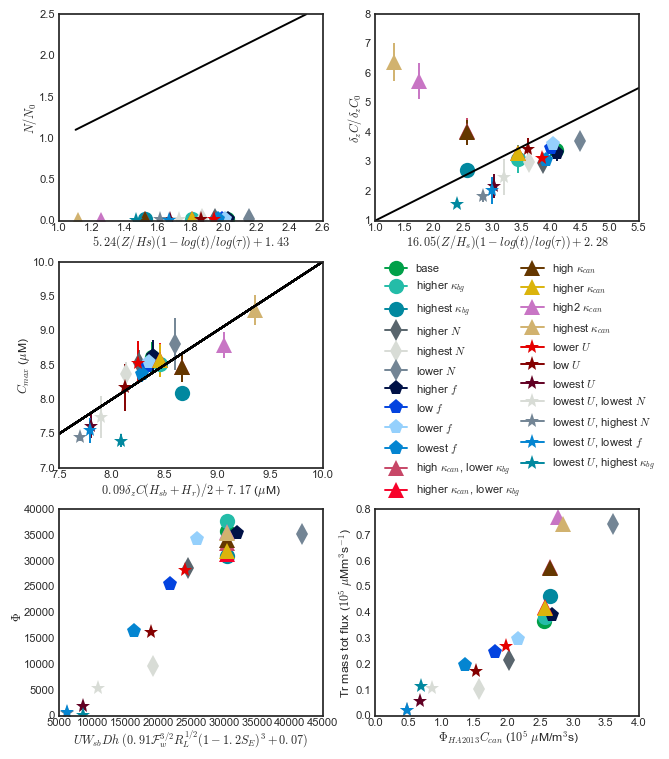

In [30]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.48,9.05)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

t=4 # days

# No

# dTr/dz
# ax.legend(bbox_to_anchor=(1.3,1)

# Tr
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    #TauNo = 1-(0.7*t*24*3600*rec.kv/(((Hs-Hh)/2)**2))
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    #plt1 = ax0.errorbar((2.6*(Z/Hs)*(TauNo))+1.02,rec.maxN/rec.N,
    #                   yerr = rec.stdN/rec.N, # since rec.N is a constant
    #                   marker = rec.mstyle,
    #                   markersize = 11,
    #                   color = sns.xkcd_rgb[rec.color],
    #                   label=rec.label)
    plt1 = ax0.errorbar((5.24*(Z/Hs)*(TauNo))+1.43,rec.maxN/rec.N,
                       yerr = rec.stdN/rec.N, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = 11,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    
    
    
    rec.tauNo = TauNo 
    rec.Z = Z
    
    ax0.set_ylabel('$N/N_0$',labelpad=0.5)
    #ax0.set_xlabel(r'$2.6(Z/Hs)(1-0.7t/\tau)+1.02$',labelpad=0.5)
    ax0.set_xlabel(r'$5.24(Z/Hs)(1-log(t)/log(\tau))+1.43$',labelpad=0.5)

ax0.plot(np.linspace(1.1, 2.5, 50),np.linspace(1.1, 2.5, 50),'k-')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    plt1 = ax1.errorbar((16.05*((Z/Hs)*(TauNo)))+2.28,rec.maxdTrdz/rec.inidTrdz,
                       yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                       marker = rec.mstyle,
                       markersize = 11,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
    #ax1.set_title('Max $\delta_zC$ below Head depth Dn' )
    ax1.set_ylabel('$\delta_zC/\delta_zC_0$',labelpad=0.5)
    ax1.set_xlabel(r'$16.05(Z/H_s)(1-log(t)/log(\tau))+2.28$',labelpad=0.5)

ax1.plot(np.linspace(1,5.5, 50),np.linspace(1,5.5, 50),'k-')


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer Conc %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    #TauNo = 1-(0.45*t*24*3600*rec.kv/((((Hs-Hh)/2)**2)))
    ax2.plot(np.linspace(7.5,10.0,50),np.linspace(7.5,10,50),'k-')
    Zdif = np.sqrt(t*3600*24*rec.kv)
    dTrdz = -rec.inidTrdz*(6.8*(((Z+Zdif)/Hs))+0.53)
    plt1 = ax2.errorbar(0.09*(dTrdz*(Hh+132.0)/2.0)+7.17,rec.maxTr,
                   yerr = rec.stdTr,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)
   
    #ax2.set_title('Max tracer concetration between head nad sh, Dn')
    ax2.set_ylabel('$C_{max}$ ($\mu$M)',labelpad=0.5)
    ax2.set_xlabel(r'$0.09\delta_zC(H_{sb}+H_r)/2+7.17$ ($\mu$M)',labelpad=0.5)


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t=4
for rec,recNoC in zip(records,recordsNoC):
    

    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    Napprox=((5.24*(Z/Hs)*(TauNo))+1.43)*rec.N
     
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    can_eff = rec.HCW-recNoC.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    #Phi = np.mean(np.array([(can_eff[ii]) for ii in range (8,14)]))
      
    plt1 = ax4.plot(HA2013*(rec.u*W*Dh(rec.f,L,rec.N)),
                    Phi,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)


    #ax4.set_title('Upwelling flux scaled as HA2013 using Napprox')
    ax4.set_ylabel('$\Phi$   ',labelpad=0.5)
    ax4.set_xlabel('$UW_{sb}Dh$ $(0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.2S_E)^3+0.07)$ ',labelpad=0.5)

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
for rec,recNoC in zip(records,recordsNoC):    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    #TauN = 1-((0.7*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauC = 1-((0.45*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauN = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    Napprox=((4.84*(Z/Hs)*(TauN))+1.49)*rec.N
    
    Zdif = np.sqrt(t*3600*24*rec.kv)
    dTrdz = -rec.inidTrdz*(6.8*(((Z+Zdif)/Hs))+0.53)
    Capprox=0.09*(dTrdz*(Hh+132.0)/2.0)+7.17
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,rec.N))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    mass_can_eff = rec.TrMassTot-recNoC.TrMassTot
    can_eff = rec.HCW-recNoC.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    #phiTr = np.mean(np.array([(mass_can_eff[ii]) for ii in range (8,14)]))
    
    #ax5.plot(np.linspace(0.5E8,3.0E8,50),np.linspace(0.5E8,3.0E8,50),'k-')
    plt1 = ax5.plot(HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                    (phiTr)/1E5,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color],
                    label=rec.label)
     
    #plt1 = ax5.plot(1000*phi*rec.maxTr, # 1000 is a conversion factor
    #                phiTr,
    #                marker = rec.mstyle,
    #                markersize = 11,
    #                color = sns.xkcd_rgb[rec.color],
    #                label=rec.label)

    #ax5.set_title('Tracer Mass upwelled scaled as $C \Phi_{HA2013}$, using N approx')
    ax5.set_xlabel(' $\Phi_{HA2013} C_{can}$ ($10^5$ $\mu$M/m$^3$s)',labelpad=0.5)
    ax5.set_ylabel('Tr mass tot flux ($10^5$ $\mu$Mm$^3$s$^{-1}$)',labelpad=0.5)

    
ax5.legend(bbox_to_anchor=(1.1,2.25),ncol=2, columnspacing=0.1)
    
ax0.tick_params(axis='x', pad=1)
ax1.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax4.tick_params(axis='x', pad=1)
ax5.tick_params(axis='x', pad=1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)
ax5.tick_params(axis='y', pad=3)

#plt.savefig('fig_scaling_estimates.eps',format='eps',bbox_inches='tight')


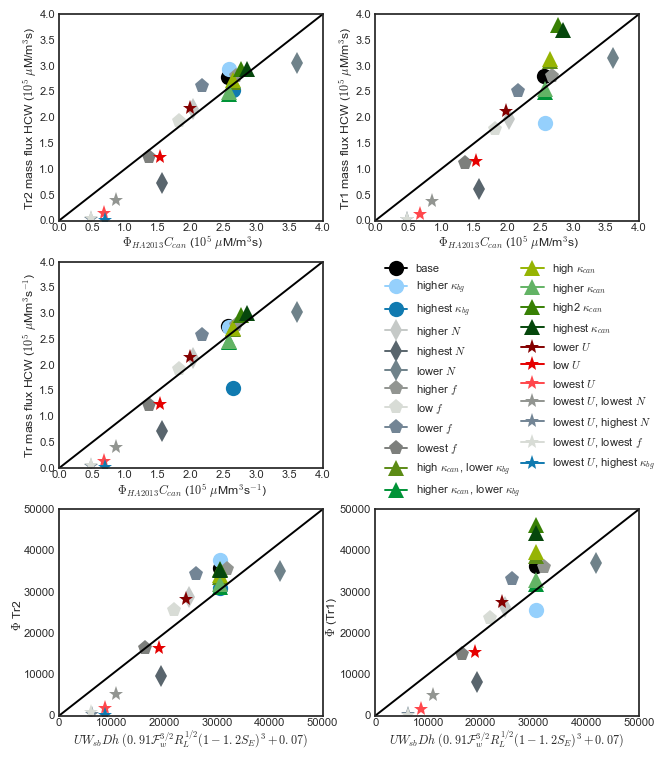

In [31]:
plt.rcParams['font.size'] = 8.0
f = plt.figure(figsize = (7.48,9.05)) # 190mm = 7.48 in, 230cm = 9.05in

gs = gspec.GridSpec(3, 2)
ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[2,0])
ax5 = plt.subplot(gs[2,1])

t=4 # days

# No

# dTr/dz
# ax.legend(bbox_to_anchor=(1.3,1)

# Tr
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
for rec,recNoC in zip(records,recordsNoC):    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
   
    TauC = 1-((0.45*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauN = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    Napprox=((4.84*(Z/Hs)*(TauN))+1.49)*rec.N
    
    Zdif = np.sqrt(t*3600*24*rec.kv)
    dTrdz = -rec.inidTrdz*(6.8*(((Z+Zdif)/Hs))+0.53)
    Capprox=0.09*(dTrdz*(Hh+132.0)/2.0)+7.17
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,rec.N))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    mass_can_eff = rec.TrMassTr2-recNoC.TrMassTr2
    can_eff = rec.HCW-recNoC.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
   
    plt1 = ax0.plot(HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                    (phiTr)/1E5,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color2],
                    label=rec.label)
     
    ax0.set_xlabel(' $\Phi_{HA2013} C_{can}$ ($10^5$ $\mu$M/m$^3$s)',labelpad=0.5)
    ax0.set_ylabel('Tr2 mass flux HCW ($10^5$ $\mu$M/m$^3$s)',labelpad=0.5)
    ax0.set_ylim(0,4)
ax0.plot(np.linspace(0,4, 50),np.linspace(0,4, 50),'k-')

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
for rec,recNoC in zip(records,recordsNoC):    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    #TauN = 1-((0.7*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauC = 1-((0.45*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauN = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    Napprox=((4.84*(Z/Hs)*(TauN))+1.49)*rec.N
    
    Zdif = np.sqrt(t*3600*24*rec.kv)
    dTrdz = -rec.inidTrdz*(6.8*(((Z+Zdif)/Hs))+0.53)
    Capprox=0.09*(dTrdz*(Hh+132.0)/2.0)+7.17
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,rec.N))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    mass_can_eff = rec.TrMassTr1-recNoC.TrMassTr1
    can_eff = rec.HCW-recNoC.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    plt1 = ax1.plot(HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                    (phiTr)/1E5,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color2],
                    label=rec.label)
     
    ax1.set_xlabel(' $\Phi_{HA2013} C_{can}$ ($10^5$ $\mu$M/m$^3$s)',labelpad=0.5)
    ax1.set_ylabel('Tr1 mass flux HCW ($10^5$ $\mu$M/m$^3$s)',labelpad=0.5)
    ax1.set_ylim(0,4)

ax1.plot(np.linspace(0,4, 50),np.linspace(0,4, 50),'k-')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t=4
for rec,recNoC in zip(records,recordsNoC):
    

    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    Napprox=((5.24*(Z/Hs)*(TauNo))+1.43)*rec.N
     
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    can_eff = rec.HCWTr1-recNoC.HCWTr1
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    #Phi = np.mean(np.array([(can_eff[ii]) for ii in range (8,14)]))
      
    plt1 = ax5.plot(HA2013*(rec.u*W*Dh(rec.f,L,rec.N)),
                    Phi,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color2],
                    label=rec.label)


    
    ax5.set_ylabel('$\Phi$ (Tr1)   ',labelpad=0.5)
    ax5.set_xlabel('$UW_{sb}Dh$ $(0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.2S_E)^3+0.07)$ ',labelpad=0.5)
    ax5.set_ylim(0,50000)

ax5.plot(np.linspace(0,50000, 50),np.linspace(0,50000, 50),'k-')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t=4
for rec,recNoC in zip(records,recordsNoC):
    

    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    TauNo = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    
    Napprox=((5.24*(Z/Hs)*(TauNo))+1.43)*rec.N
     
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    can_eff = rec.HCW-recNoC.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    #Phi = np.mean(np.array([(can_eff[ii]) for ii in range (8,14)]))
      
    plt1 = ax4.plot(HA2013*(rec.u*W*Dh(rec.f,L,rec.N)),
                    Phi,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color2],
                    label=rec.label)


    #ax4.set_title('Upwelling flux scaled as HA2013 using Napprox')
    ax4.set_ylabel('$\Phi$ Tr2  ',labelpad=0.5)
    ax4.set_xlabel('$UW_{sb}Dh$ $(0.91\mathcal{F}_w^{3/2}R_L^{1/2}(1-1.2S_E)^3+0.07)$ ',labelpad=0.5)
    ax4.set_ylim(0,50000)
ax4.plot(np.linspace(0,50000, 50),np.linspace(0,50000, 50),'k-')

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
for rec,recNoC in zip(records,recordsNoC):    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    #TauN = 1-((0.7*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauC = 1-((0.45*t*24*3600*rec.kv)/(((Hs-Hh)/2)**2))
    TauN = 1-(np.log(t*24*3600)/np.log((((Hs-Hh)/2)**2)/rec.kv))
    Napprox=((4.84*(Z/Hs)*(TauN))+1.49)*rec.N
    
    Zdif = np.sqrt(t*3600*24*rec.kv)
    dTrdz = -rec.inidTrdz*(6.8*(((Z+Zdif)/Hs))+0.53)
    Capprox=0.09*(dTrdz*(Hh+132.0)/2.0)+7.17
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,rec.N))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    mass_can_eff = rec.TrMass-recNoC.TrMass
    can_eff = rec.HCW-recNoC.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,14)]))
    
    plt1 = ax2.plot(HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                    (phiTr)/1E5,
                    marker = rec.mstyle,
                    markersize = 11,
                    color = sns.xkcd_rgb[rec.color2],
                    label=rec.label)
     
    ax2.set_xlabel(' $\Phi_{HA2013} C_{can}$ ($10^5$ $\mu$Mm$^3$s$^{-1}$)',labelpad=0.5)
    ax2.set_ylabel('Tr mass flux HCW ($10^5$ $\mu$Mm$^3$s$^{-1}$)',labelpad=0.5)

    ax2.set_ylim(0,4)
ax2.plot(np.linspace(0,4, 50),np.linspace(0,4, 50),'k-')

    
ax5.legend(bbox_to_anchor=(1.1,2.25),ncol=2, columnspacing=0.1)
    
ax0.tick_params(axis='x', pad=1)
ax1.tick_params(axis='x', pad=1)
ax2.tick_params(axis='x', pad=1)
ax4.tick_params(axis='x', pad=1)
ax5.tick_params(axis='x', pad=1)

ax0.tick_params(axis='y', pad=3)
ax1.tick_params(axis='y', pad=3)
ax2.tick_params(axis='y', pad=3)
ax4.tick_params(axis='y', pad=3)
ax5.tick_params(axis='y', pad=3)

#plt.savefig('fig_scaling_estimates.eps',format='eps',bbox_inches='tight')


## Individual plots for talks

In [32]:

labels_Bark = ['Lin','Sal','Oxy','Nit','Sil','Pho','NitA','Met']
colours_Bark = ['purple','blue','green','gold','orange','red','orchid','teal']


PhiTr_scaled_barkley = [981713.2 ,1021419.4,-5917704.4,1439242.2,2458652.0,67971.1,907062.9,3573535.6]
 
PhiTr_model_barkley =  [1093887.3,1148391.8,3480067.7,1115451.9,1626847.6,76542.7,901950.0,777955.9]

The rms error for N/No above is 0.065758
The rms error for N/N0 below is 0.131458
The sigma error for dTrdz CNTDIFF_run38 is 0.554051
The sigma error for dTrdz CNTDIFF_run37 is 10.946186
The sigma error for dTrdz CNTDIFF_run36 is 26.754010
The sigma error for dTrdz CNTDIFF_run45 is 4.924001
The sigma error for dTrdz CNTDIFF_run73 is 6.144353
The sigma error for dTrdz CNTDIFF_run75 is 7.452072
The sigma error for dTrdz CNTDIFF_run67 is 4.635381
The sigma error for dTrdz CNTDIFF_run51 is 4.867616
The sigma error for dTrdz CNTDIFF_run69 is 6.764974
The sigma error for dTrdz CNTDIFF_run71 is 4.420204
The sigma error for dTrdz 3DVISC_run01 is 7.012299
The sigma error for dTrdz 3DVISC_run02 is 12.623692
The sigma error for dTrdz 3DVISC_run03 is 7.590184
The sigma error for dTrdz 3DVISC_run04 is 12.331702
The sigma error for dTrdz 3DVISC_run05 is 5.902235
The sigma error for dTrdz 3DVISC_run06 is 2.548836
The sigma error for dTrdz LOWER_BF_run01 is 1.759185
The sigma error for dTrdz LOW_BF_ru

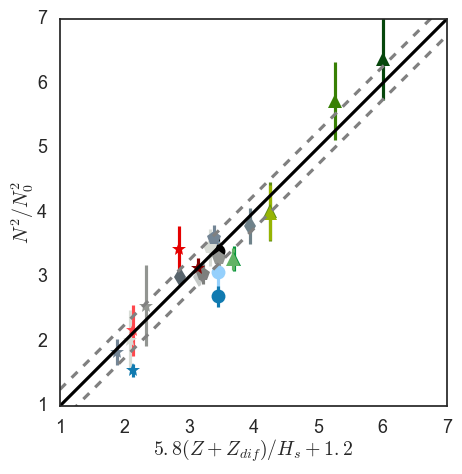

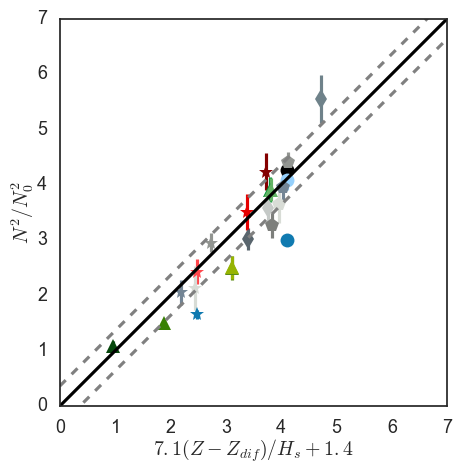

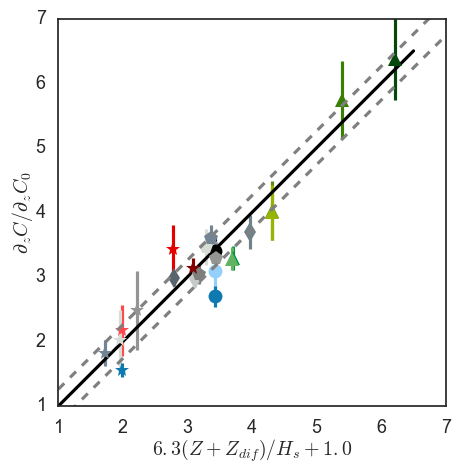

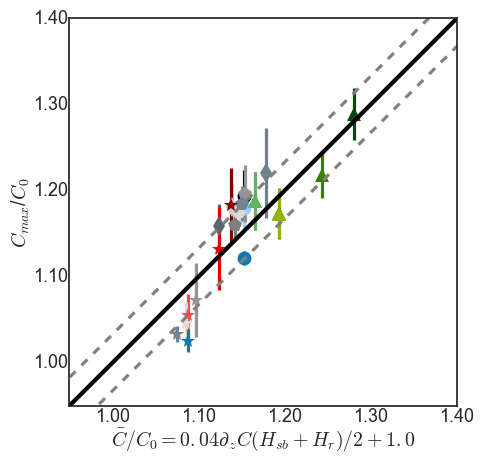

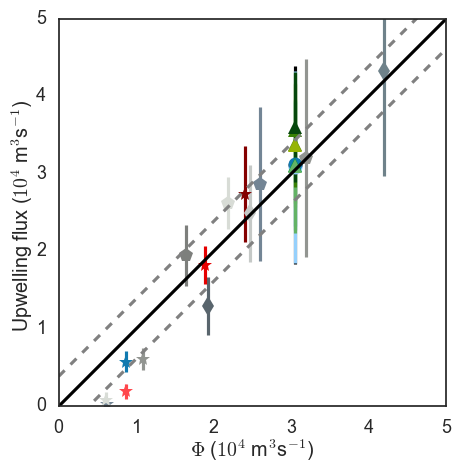

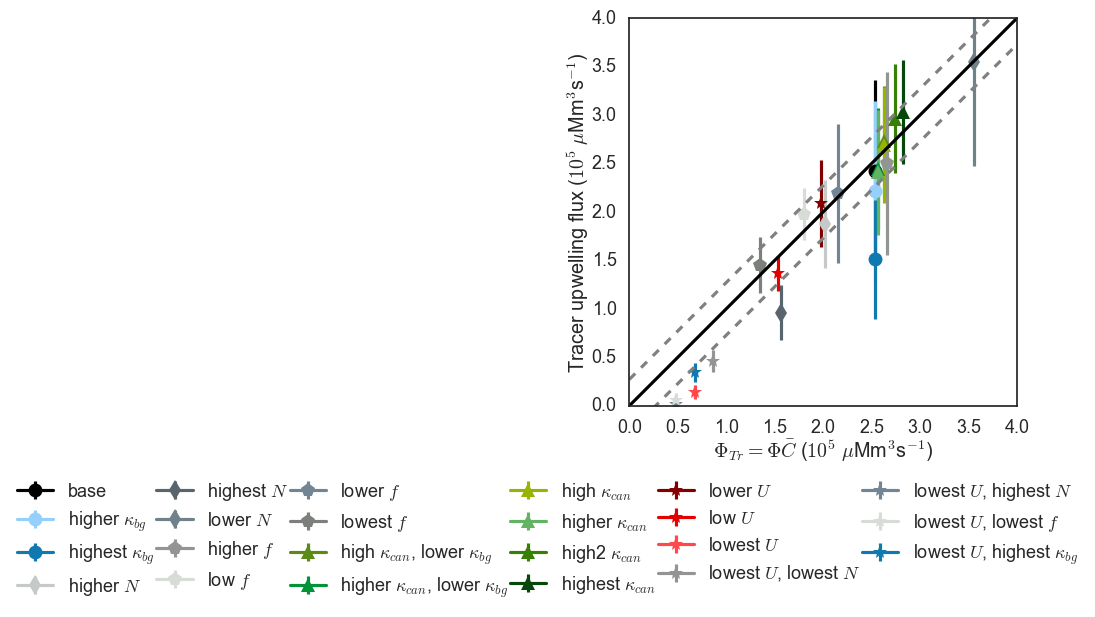

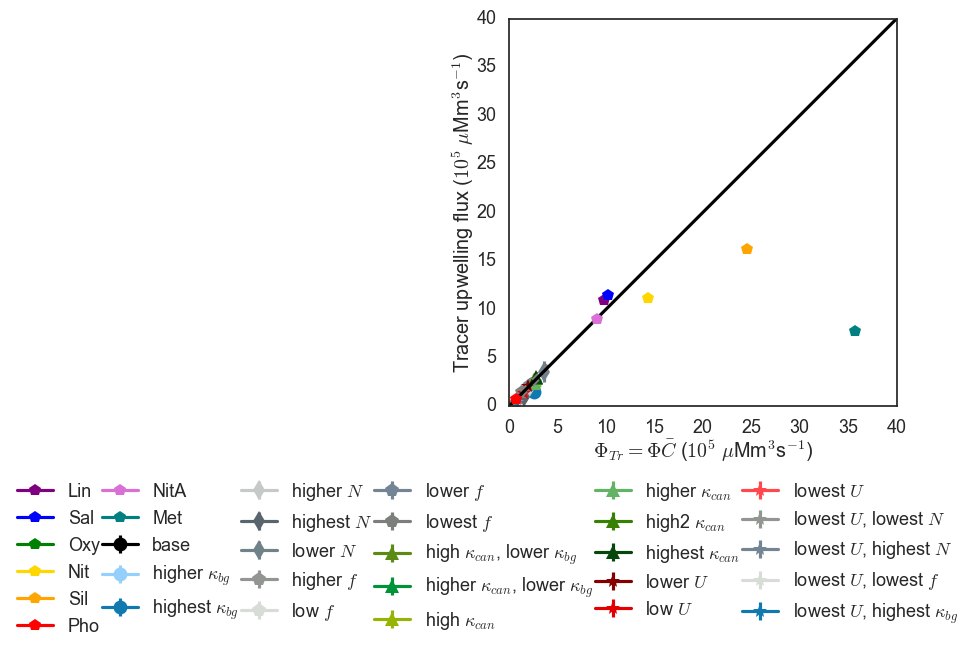

In [39]:
sns.set_context('talk')
f0,ax0 = plt.subplots(1,1,figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

t=5 # days

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No above %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for rec,recNoC in zip(records,recordsNoC):
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg)) 
    
    
    plt1 = ax0.errorbar((5.76*((Z+Zdif)/Hs))+1.20,rec.maxNabove/(rec.N**2),
                        yerr = rec.stdNabove/(rec.N**2), # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    
    rec.Z = Z
    rec.Zdif = Zdif
    
    ax0.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
    ax0.set_xlabel(r'$5.8(Z+Z_{dif})/H_s+1.2$',labelpad=0.5)

maxN_array_Kv = np.array([rec.maxNabove/(rec.N**2) for rec in records2])
tilt_array_Kv = np.array([(rec.Z+rec.Zdif)/Hs for rec in records2])
x_fit = np.linspace(1.0, 7, 50)

mean_sq_err = np.mean(((maxN_array_Kv)-(5.76*tilt_array_Kv+1.20))**2)
upper_bound = ax0.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax0.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for N/No above is %f' %mean_sq_err)

ax0.plot(np.linspace(1.0, 7, 50),np.linspace(1.0, 7, 50),'k-')

ax0.set_ylim(1,7)
ax0.set_xlim(1,7)

plt.savefig('scaling_topN.eps',format='eps',bbox_inches='tight')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% N/No %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
f1,ax1 = plt.subplots(1,1,figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in
for rec,recNoC in zip(records,recordsNoC):
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg)) 
    
    
    plt1 = ax1.errorbar((7.07*((Z-Zdif)/Hs))+1.35,rec.maxN/(rec.N**2),
                        yerr = rec.stdN/(rec.N**2), # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    
    rec.Z = Z
     
    ax1.set_ylabel('$N^2/N^2_0$',labelpad=0.5)
    ax1.set_xlabel(r'$7.1(Z-Z_{dif})/H_s+1.4$',labelpad=0.5)

maxN_array = np.array([rec.maxN/(rec.N**2) for rec in records2])
tilt_array = np.array([((rec.Z-rec.Zdif)/Hs) for rec in records2])
x_fit = np.linspace(0, 7, 50)

mean_sq_err = np.mean((maxN_array-(7.07*tilt_array+1.35))**2)

upper_bound = ax1.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax1.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for N/N0 below is %f' %mean_sq_err)

ax1.plot(np.linspace(0, 7, 50),np.linspace(0, 7, 50),'k-')
ax1.set_ylim(0,7)
ax1.set_xlim(0,7)
plt.savefig('scaling_N.eps',format='eps',bbox_inches='tight')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% dTr/dz %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
f2,ax2 = plt.subplots(1,1,figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

ax2.plot(np.linspace(1,6.5, 50),np.linspace(1,6.5, 50),'k-')

for rec,recNoC in zip(records,recordsNoC):
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    plt1 = ax2.errorbar(6.27*((Z+Zdif)/Hs)+0.98,rec.maxdTrdz/rec.inidTrdz,
                        yerr = rec.stddTrdz/rec.inidTrdz, # since rec.N is a constant
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
   
    rec.Z = Z
    rec.Zdif = Zdif
    ax2.set_ylabel('$\partial_zC/\partial_zC_0$',labelpad=0.5)
    ax2.set_xlabel(r'$6.3(Z+Z_{dif})/H_s+1.0$',labelpad=0.5)
    dz = 6.27*((Z+Zdif)/Hs)+0.98
    err_dzC = abs(1-(dz/(rec.maxdTrdz/rec.inidTrdz)))*100
    print('The sigma error for dTrdz %s is %f' %(rec.name,err_dzC))

maxN_array = np.array([rec.maxdTrdz/rec.inidTrdz for rec in records2])
tilt_array = np.array([(rec.Z+rec.Zdif)/Hs for rec in records2])
x_fit = np.linspace(1,7, 50)

mean_sq_err = np.mean(((maxN_array)-(6.27*tilt_array+0.98))**2)
upper_bound = ax2.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax2.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for dTr/dz above is %f' %mean_sq_err)
ax2.set_ylim(1,7)
ax2.set_xlim(1,7)
plt.savefig('scaling_dC.eps',format='eps',bbox_inches='tight')

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Tracer Conc %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
f3,ax3 = plt.subplots(1,1,figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

for rec in records:
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    ax3.plot(np.linspace(0,1.4,50),np.linspace(0,1.4,50),'k-')
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    dTrdz = -rec.inidTrdz*(6.27*(((Z+Zdif)/Hs))+0.98)
    plt1 = ax3.errorbar((0.08*(dTrdz*(Hh+132.0)/2.0))/rec.TrSB + 7.19/rec.TrSB,rec.maxTr/rec.TrSB,
                        yerr = rec.stdTr/rec.TrSB,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    rec.Z = Z
    rec.Zdif = Zdif
    rec.dTr = dTrdz
    ax3.set_xlim(0.95,1.4)
    ax3.set_ylim(0.95,1.4)
    #ax3.set_title('Max tracer concetration between head nad sh, Dn')
    ax3.set_ylabel('$C_{max}$/$C_{0}$',labelpad=0.5)
    ax3.set_xlabel(r'$\bar{C}/C_{0}=%1.2f\partial_zC(H_{sb}+H_r)/2+%1.1f$' %((0.08/2),(7.19/rec.TrSB)),labelpad=0.5)
    C = (0.08*(dTrdz*(Hh+132.0)/2.0)) + 7.19
    err_C = abs(1-(C/rec.maxTr))*100
    print('The sigma error for bar{C} %s is %f' %(rec.name,err_C))

fmt = FormatStrFormatter('%1.2f')
ax3.xaxis.set_major_formatter(fmt)
ax3.yaxis.set_major_formatter(fmt)

ax3.tick_params(axis='x', pad=1)
ax3.tick_params(axis='y', pad=1)

maxN_array = np.array([rec.maxTr/rec.TrSB for rec in records2])
tilt_array = np.array([(0.08*(rec.dTr*(Hh+132.0)/2.0))/rec.TrSB+7.19/rec.TrSB for rec in records2])
x_fit = np.linspace(0,1.4, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax3.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax3.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for C/Co is %f' %mean_sq_err)

plt.savefig('scaling_C.eps',format='eps',bbox_inches='tight')


# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
f4,ax4 = plt.subplots(1,1,figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

t=4
for rec,recNoC in zip(records,recordsNoC):
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    
    HA2013=((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    can_eff = rec.HCW
    Phi = np.mean(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    Phi_std = np.std(np.array([(can_eff[ii]-can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    #Phi = np.mean(np.array([(can_eff[ii]) for ii in range (8,14)]))
      
    plt1 = ax4.errorbar(HA2013*(rec.u*W*Dh(rec.f,L,rec.N))/1E4,Phi/1E4,
                        yerr=Phi_std/1E4,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    rec.Phi = Phi/1E4
    rec.HA2013 = HA2013*(rec.u*W*Dh(rec.f,L,rec.N))/1E4

#ax4.set_title('Upwelling flux scaled as HA2013 using Napprox')
ax4.set_ylabel(r'Upwelling flux ($10^4$ m$^3$s$^{-1}$)  ',labelpad=0.5)
ax4.set_xlabel(r'$\Phi$ ($10^4$ m$^3$s$^{-1}$)',labelpad=0.5)
    
maxN_array = np.array([rec.Phi for rec in records3])
tilt_array = np.array([rec.HA2013 for rec in records3])
x_fit = np.linspace(0,5, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax4.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax4.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for Phi is %f' %mean_sq_err)

ax4.plot(np.linspace(0,5, 50),np.linspace(0,5, 50),'k-')
ax4.set_ylim(0,5.0)
plt.savefig('scaling_Phi.eps',format='eps',bbox_inches='tight')
    
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
f5,ax5 = plt.subplots(1,1,figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

for rec,recNoC in zip(records,recordsNoC):    
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    
    Capprox=(0.08*(rec.dTr*(Hh+132.0)/2.0))+7.19
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,rec.N))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    mass_can_eff = rec.TrMass
    can_eff = rec.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    phiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    plt1 = ax5.errorbar(HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                        (phiTr)/1E5,
                        yerr = phiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    rec.PhiTr = (phiTr)/1E5
    rec.PhiTrScale = HA2013*(Capprox)/1E5
     
ax5.set_xlabel(r'$\Phi_{Tr}=\Phi \bar{C}$ ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)
ax5.set_ylabel(r'Tracer upwelling flux ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)

maxN_array = np.array([rec.PhiTr for rec in records3])
tilt_array = np.array([rec.PhiTrScale for rec in records3])
x_fit = np.linspace(0,4, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax5.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax5.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
print('The rms error for PhiTr/1E5 above is %f' %mean_sq_err)

ax5.set_ylim(0,4)
ax5.plot(np.linspace(0,4, 50),np.linspace(0,4, 50),'k-')
plt.savefig('scaling_PhiTr.eps',format='eps',bbox_inches='tight')


ax5.legend(bbox_to_anchor=(1.2,-0.15),ncol=6, columnspacing=0.1)

    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Phi_Tr with barkley profiles %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%    
f6,ax6 = plt.subplots(1,1,figsize = (5,5)) # 190mm = 7.48 in, 230cm = 9.05in

for rec,recNoC in zip(records,recordsNoC):    
    
    Z = ((rec.f*rec.u*F(Ro(rec.u,rec.f,R))*L)**(0.5))/rec.N
    Zdif = np.sqrt(t*3600*24*(rec.kv-rec.kbg))
    
    Capprox=(0.08*(rec.dTr*(Hh+132.0)/2.0))+7.19
    
    Se = (s*rec.N)/(rec.f*((F(Ro(rec.u,rec.f,W))/Ro(rec.u,rec.f,L))**(1/2)))
    HA2013=(rec.u*W*Dh(rec.f,L,rec.N))*((0.91*(F(Ro(rec.u,rec.f,W))**(3/2))*(Ro(rec.u,rec.f,L)**(1/2))*((1-1.21*Se)**3))+0.07)
    
    mass_can_eff = rec.TrMass
    can_eff = rec.HCW
    
    phiTr = np.mean(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    phiTr_std = np.std(np.array([(mass_can_eff[ii]-mass_can_eff[ii-1])/(time[ii]-time[ii-1]) for ii in range (8,18)]))
    
    plt1 = ax6.errorbar(HA2013*(Capprox)/1E5, # 1000 is a conversion factor
                        (phiTr)/1E5,
                        yerr = phiTr_std/1E5,
                        marker = rec.mstyle,
                        markersize = 10,
                        color = sns.xkcd_rgb[rec.color2],
                        label=rec.label)
    rec.PhiTr = (phiTr)/1E5
    rec.PhiTrScale = HA2013*(Capprox)/1E5
    err_phi = abs(1-((HA2013*(Capprox))/phiTr))*100
    print('The sigma error for PhiTr/1E5  %s is %f' %(rec.name,err_phi))
ax6.set_xlabel(r'$\Phi_{Tr}=\Phi \bar{C}$ ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)
ax6.set_ylabel(r'Tracer upwelling flux ($10^5$ $\mu$Mm$^{3}$s$^{-1}$)',labelpad=0.5)

maxN_array = np.array([rec.PhiTr for rec in records3])
tilt_array = np.array([rec.PhiTrScale for rec in records3])
x_fit = np.linspace(0,4, 50)

mean_sq_err = np.mean(((maxN_array)-(tilt_array))**2)
upper_bound = ax6.plot(x_fit,x_fit+(mean_sq_err)**(0.5),linestyle = '--',color='0.5')
lower_bound = ax6.plot(x_fit,x_fit-(mean_sq_err)**(0.5),linestyle = '--',color='0.5')


ax6.plot(np.linspace(0,40, 50),np.linspace(0,40, 50),'k-')

for TrMass,Trmodel, lab, col in zip(PhiTr_scaled_barkley, PhiTr_model_barkley,labels_Bark,colours_Bark):
    ax6.plot(TrMass/1E5, Trmodel/1E5, color=col, label=lab, marker='p')
    
ax6.set_ylim(0,40)
ax6.set_xlim(0,40)



ax6.legend(bbox_to_anchor=(1.2,-0.15),ncol=6, columnspacing=0.1)
plt.savefig('scaling_PhiTr_wBarkley.eps',format='eps',bbox_inches='tight')
